In [61]:
# Setup
import os
from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

DBUNAME = os.environ.get("DBUNAME")
DBPASSWORD = os.environ.get("DBPASSWORD")
DBHOST = os.environ.get("DBHOST")
DBPORT = os.environ.get("DBPORT")
DBNAME = os.environ.get("DBNAME")

import sqlalchemy
import psycopg2

connection_str = 'postgresql+psycopg2://'+DBUNAME+':'+DBPASSWORD+'@'+DBHOST+':'+DBPORT+'/'+DBNAME

In [62]:
try:
    engine = sqlalchemy.create_engine(connection_str)
    conn = engine.connect()
except:
    print('Database connection error - check creds')

In [63]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.style as style
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from matplotlib import rcParams

# What is the balance of trade for our countries of interest?
```
A priority should be to get Fiji & Vanuatu monthly/ quarterly GDP data and focus on one the Polynesian state (Kiribati) and one in Micronesia (Palau)?
That way, we’ll cover the three regions of the Pacific: 

(Fiji and Vanuatu = Melanesia (big exporters); 

Cook Islands and Kiribati = Polynesia (survive on imports); 

Palau = Micronesia (tourism represents around 40% of GDP and often employs a significant proportion of people in formal employment + 86% of its exports).
```

In [37]:
pd.read_sql("select distinct country from public.country_metrics where category = 'trade'",con=engine)

,country
0,pl
1,ki
2,sb
3,ws
4,fj
5,vn
6,ck


In [39]:
# are the countries available?
pd.read_sql(
"""
select country, frequency, name, min(date), max(date)
from public.country_metrics
where true
and category = 'trade'
-- and country in ('fj','vn','ck','ki','pw','sb')
and country = 'pl'
group by 1,2,3
order by 1,2,3
"""
,con=engine)

,country,frequency,name,min,max
0,pl,monthly,exports-fob-domestic,2018-01-01,2019-12-01
1,pl,monthly,exports-fob-reexport,2018-01-01,2019-12-01
2,pl,monthly,exports-fob-total,2018-01-01,2019-12-01
3,pl,monthly,imports-cif,2018-01-01,2019-12-01
4,pl,monthly,trade-balance,2018-01-01,2019-12-01


In [15]:
# analytics query
data_trade = pd.read_sql(
"""
        with model as (
            select
                date
                ,case 
                    when country in ('fj','vn','sb') then 'melanesia'
                    when country in ('ck','ki') then 'polynesia'
                    when country in ('pw','pl') then 'micronesia'
                 end as region
                ,case when country = 'pl' then 'pw'
                     else country end as country
                ,case 
                    when (country = 'vn' and name='total-imports') then 1000000*cast(value as float)
                    when (country = 'pl' and name='imports-cif') then cast(value as float)
                    when (country not in ('pl','vn') and name='imports-cif') then 1000*cast(value as float)
                    else 0 
                 end as trade_imports
                ,case 
                    when (country = 'vn' and name='total-exports') then 1000000*cast(value as float)
                    when (country = 'pl' and name='exports-fob-total') then cast(value as float)
                    when (country not in ('pl','vn') and name='exports-fob-total') then 1000*cast(value as float)
                    else 0 
                 end as trade_exports
            from public.country_metrics
            where true
                and category = 'trade'
                and frequency = 'monthly'
                and country in ('fj','vn','ck','ki','pw','pl','sb')
                and date between '2019-01-01' and '2019-12-31'
        )
        select 
            region
            ,country
            ,date            
            ,sum(trade_imports) as trade_imports
            ,sum(trade_exports) as trade_exports
            ,sum(trade_imports) + sum(trade_exports) as trade_volume
            ,sum(trade_exports) - sum(trade_imports) as trade_balance
            ,sum(trade_exports)/sum(trade_imports) as export_import_ratio
        from model   
        group by 1,2,3
        order by 1,2,3   
"""
,con=engine)
data_trade

,region,country,date,trade_imports,trade_exports,trade_volume,trade_balance,export_import_ratio
0,melanesia,fj,2019-01-01,6.030260e+08,2.091587e+08,8.121847e+08,-3.938673e+08,0.346849
1,melanesia,fj,2019-02-01,3.612810e+08,1.602607e+08,5.215417e+08,-2.010203e+08,0.443590
2,melanesia,fj,2019-03-01,3.864050e+08,1.682713e+08,5.546763e+08,-2.181337e+08,0.435479
3,melanesia,fj,2019-04-01,4.271140e+08,1.666927e+08,5.938067e+08,-2.604213e+08,0.390277
4,melanesia,fj,2019-05-01,4.626890e+08,1.790928e+08,6.417818e+08,-2.835962e+08,0.387069
...,...,...,...,...,...,...,...,...
67,polynesia,ki,2019-08-01,1.564470e+07,2.192664e+06,1.783737e+07,-1.345204e+07,0.140154
68,polynesia,ki,2019-09-01,1.484654e+07,1.375781e+06,1.622232e+07,-1.347076e+07,0.092667
69,polynesia,ki,2019-10-01,1.619253e+07,7.567212e+05,1.694925e+07,-1.543581e+07,0.046733
70,polynesia,ki,2019-11-01,1.269483e+07,1.412641e+06,1.410747e+07,-1.128219e+07,0.111277


In [137]:
with engine.connect() as con:
    con.execute("""
    drop table if exists public.stg_trade_agg;
    create table public.stg_trade_agg as 
        with model as (
            select
                date
                ,case 
                    when country in ('fj','vn','sb') then 'melanesia'
                    when country in ('ck','ki') then 'polynesia'
                    when country in ('pw','pl') then 'micronesia'
                 end as region
                ,case when country = 'pl' then 'pw'
                     else country end as country
                ,case 
                    when (country = 'vn' and name='total-imports') then 1000000*cast(value as float)
                    when (country = 'pl' and name='imports-cif') then cast(value as float)
                    when (country not in ('pl','vn') and name='imports-cif') then 1000*cast(value as float)
                    else 0 
                 end as trade_imports
                ,case 
                    when (country = 'vn' and name='total-exports') then 1000000*cast(value as float)
                    when (country = 'pl' and name='exports-fob-total') then cast(value as float)
                    when (country not in ('pl','vn') and name='exports-fob-total') then 1000*cast(value as float)
                    else 0 
                 end as trade_exports
            from public.country_metrics
            where true
                and category = 'trade'
                and frequency = 'monthly'
                and country in ('fj','vn','ck','ki','pw','pl','sb')
 --               and date between '2019-01-01' and '2020-07-31'
        )
        select 
            date
            ,region
            ,country
            ,sum(trade_imports) as trade_imports
            ,sum(trade_exports) as trade_exports
            ,sum(trade_imports) + sum(trade_exports) as trade_volume
            ,sum(trade_exports) - sum(trade_imports) as trade_balance
            ,sum(trade_exports)/sum(trade_imports) as export_import_ratio
        from model   
        group by 1,2,3
        order by 1,2,3    
    ;;
    """)

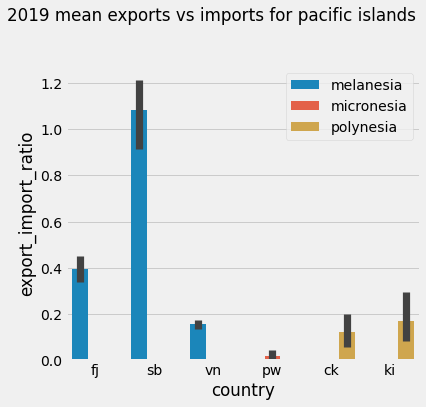

In [65]:
import matplotlib.style as style
style.use('fivethirtyeight')
plt.clf
f = plt.figure(figsize=(6,6))

sns.barplot(x='country',y='export_import_ratio',hue='region',data=data_trade)
plt.suptitle('2019 mean exports vs imports for pacific islands',x=0.01, y=.975,ha='left')
plt.legend(loc='upper right')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

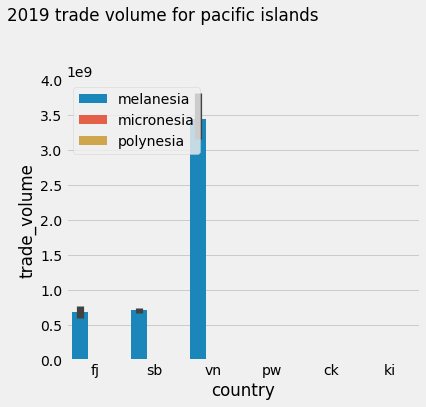

In [64]:
import matplotlib.style as style
style.use('fivethirtyeight')
plt.clf
f = plt.figure(figsize=(6,6))

sns.barplot(x='country',y='trade_volume',hue='region',data=data_trade)
plt.suptitle('2019 trade volume for pacific islands',x=0.01, y=.975,ha='left')
plt.legend(loc='upper left')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# How does AIS port calls compare to our Port Calls?

In [14]:
data_port_calls = pd.read_sql("""
select
    country
    ,date_trunc('month',"date-entry") as date
    ,sum(port_calls) as port_calls
from public.ais_port_calls
where true
    and "date-entry" between '2019-04-01' and '2020-07-31'
group by 1,2
order by 1,2
""",con=engine)
data_port_calls

,country,date,port_calls
0,ck,2019-04-01,2.0
1,ck,2019-05-01,3.0
2,ck,2019-06-01,2.0
3,ck,2019-07-01,3.0
4,ck,2019-08-01,5.0
...,...,...,...
91,vu,2020-03-01,11.0
92,vu,2020-04-01,12.0
93,vu,2020-05-01,11.0
94,vu,2020-06-01,12.0


In [27]:
# analytics query
data_trade2 = pd.read_sql(
"""
        with model as (
            select
                date
                ,case 
                    when country in ('fj','vn','sb') then 'melanesia'
                    when country in ('ck','ki') then 'polynesia'
                    when country in ('pw','pl') then 'micronesia'
                 end as region
                ,case when country = 'pl' then 'pw'
                     when country = 'vn' then 'vu'
                     else country end as country
                ,case 
                    when (country = 'vn' and name='total-imports') then 1000000*cast(value as float)
                    when (country = 'pl' and name='imports-cif') then cast(value as float)
                    when (country not in ('pl','vn') and name='imports-cif') then 1000*cast(value as float)
                    else 0 
                 end as trade_imports
                ,case 
                    when (country = 'vn' and name='total-exports') then 1000000*cast(value as float)
                    when (country = 'pl' and name='exports-fob-total') then cast(value as float)
                    when (country not in ('pl','vn') and name='exports-fob-total') then 1000*cast(value as float)
                    else 0 
                 end as trade_exports
            from public.country_metrics
            where true
                and category = 'trade'
                and frequency = 'monthly'
                and country in ('fj','vn','ck','ki','pw','pl','sb')
                and date between '2019-01-01' and '2020-07-31'
        )
        select 
            region
            ,country
            ,date            
            ,sum(trade_imports) as trade_imports
            ,sum(trade_exports) as trade_exports
            ,sum(trade_imports) + sum(trade_exports) as trade_volume
            ,sum(trade_exports) - sum(trade_imports) as trade_balance
            ,sum(trade_exports)/sum(trade_imports) as export_import_ratio
        from model   
        group by 1,2,3
        order by 1,2,3   
"""
,con=engine,parse_dates='date')
data_trade2

,region,country,date,trade_imports,trade_exports,trade_volume,trade_balance,export_import_ratio
0,melanesia,fj,2019-01-01,6.030260e+08,2.091587e+08,8.121847e+08,-3.938673e+08,0.346849
1,melanesia,fj,2019-02-01,3.612810e+08,1.602607e+08,5.215417e+08,-2.010203e+08,0.443590
2,melanesia,fj,2019-03-01,3.864050e+08,1.682713e+08,5.546763e+08,-2.181337e+08,0.435479
3,melanesia,fj,2019-04-01,4.271140e+08,1.666927e+08,5.938067e+08,-2.604213e+08,0.390277
4,melanesia,fj,2019-05-01,4.626890e+08,1.790928e+08,6.417818e+08,-2.835962e+08,0.387069
...,...,...,...,...,...,...,...,...
67,polynesia,ki,2019-08-01,1.564470e+07,2.192664e+06,1.783737e+07,-1.345204e+07,0.140154
68,polynesia,ki,2019-09-01,1.484654e+07,1.375781e+06,1.622232e+07,-1.347076e+07,0.092667
69,polynesia,ki,2019-10-01,1.619253e+07,7.567212e+05,1.694925e+07,-1.543581e+07,0.046733
70,polynesia,ki,2019-11-01,1.269483e+07,1.412641e+06,1.410747e+07,-1.128219e+07,0.111277


In [28]:
data_merge = data_trade2.merge(data_port_calls,on=['country','date'],how='outer')
data_merge['region'] = data_merge['region'].ffill()
data_merge

,region,country,date,trade_imports,trade_exports,trade_volume,trade_balance,export_import_ratio,port_calls
0,melanesia,fj,2019-01-01,603026000.0,209158690.0,812184690.0,-393867310.0,0.346849,NaN
1,melanesia,fj,2019-02-01,361281000.0,160260704.0,521541704.0,-201020296.0,0.443590,NaN
2,melanesia,fj,2019-03-01,386405000.0,168271325.0,554676325.0,-218133675.0,0.435479,NaN
3,melanesia,fj,2019-04-01,427114000.0,166692659.0,593806659.0,-260421341.0,0.390277,56.0
4,melanesia,fj,2019-05-01,462689000.0,179092751.0,641781751.0,-283596249.0,0.387069,56.0
...,...,...,...,...,...,...,...,...,...
109,polynesia,vu,2020-03-01,NaN,NaN,NaN,NaN,NaN,11.0
110,polynesia,vu,2020-04-01,NaN,NaN,NaN,NaN,NaN,12.0
111,polynesia,vu,2020-05-01,NaN,NaN,NaN,NaN,NaN,11.0
112,polynesia,vu,2020-06-01,NaN,NaN,NaN,NaN,NaN,12.0


In [31]:
data_merge[data_merge.country=='sb']
# july 2019 = 100

,region,country,date,trade_imports,trade_exports,trade_volume,trade_balance,export_import_ratio,port_calls
17,melanesia,sb,2019-01-01,3.243075e+08,393751610.5,7.180591e+08,6.944411e+07,1.214130,NaN
18,melanesia,sb,2019-02-01,3.150493e+08,355319176.1,6.703684e+08,4.026992e+07,1.127821,NaN
19,melanesia,sb,2019-03-01,3.912390e+08,357255455.4,7.484944e+08,-3.398350e+07,0.913139,NaN
91,polynesia,sb,2019-04-01,NaN,NaN,NaN,NaN,NaN,56.0
92,polynesia,sb,2019-05-01,NaN,NaN,NaN,NaN,NaN,68.0
93,polynesia,sb,2019-06-01,NaN,NaN,NaN,NaN,NaN,66.0
94,polynesia,sb,2019-07-01,NaN,NaN,NaN,NaN,NaN,56.0
95,polynesia,sb,2019-08-01,NaN,NaN,NaN,NaN,NaN,51.0
96,polynesia,sb,2019-09-01,NaN,NaN,NaN,NaN,NaN,53.0
97,polynesia,sb,2019-10-01,NaN,NaN,NaN,NaN,NaN,45.0


In [30]:
data_norm = data_merge[data_merge.date=='2019-07-01'].copy()
data_norm

,region,country,date,trade_imports,trade_exports,trade_volume,trade_balance,export_import_ratio,port_calls
6,melanesia,fj,2019-07-01,4.772950e+08,215149129.0,6.924441e+08,-2.621459e+08,0.450768,61.0
26,melanesia,vu,2019-07-01,2.568000e+09,520000000.0,3.088000e+09,-2.048000e+09,0.202492,18.0
38,micronesia,pw,2019-07-01,1.677977e+07,81537.0,1.686131e+07,-1.669823e+07,0.004859,5.0
50,polynesia,ck,2019-07-01,1.716100e+07,5752000.0,2.291300e+07,-1.140900e+07,0.335179,3.0
66,polynesia,ki,2019-07-01,1.535896e+07,1119223.4,1.647818e+07,-1.423973e+07,0.072871,7.0
94,polynesia,sb,2019-07-01,NaN,NaN,NaN,NaN,NaN,56.0


In [58]:
data_merge = data_merge[~data_merge.country.isin(['sb'])].merge(data_norm[['country','trade_volume','port_calls']],on=['country'])
data_merge['trade_volume_norm'] = 100*data_merge.trade_volume_x/data_merge.trade_volume_y
data_merge['port_calls_norm'] = 100*data_merge.port_calls_x/data_merge.port_calls_y
data_merge

,region,country,date,trade_imports,trade_exports,trade_volume_x,trade_balance,export_import_ratio,port_calls_x,trade_volume_y,port_calls_y,trade_volume_norm,port_calls_norm,trade_volume,port_calls
0,melanesia,fj,2019-01-01,603026000.0,209158690.0,812184690.0,-393867310.0,0.346849,NaN,6.924441e+08,61.0,117.292451,NaN,6.924441e+08,61.0
1,melanesia,fj,2019-02-01,361281000.0,160260704.0,521541704.0,-201020296.0,0.443590,NaN,6.924441e+08,61.0,75.318958,NaN,6.924441e+08,61.0
2,melanesia,fj,2019-03-01,386405000.0,168271325.0,554676325.0,-218133675.0,0.435479,NaN,6.924441e+08,61.0,80.104127,NaN,6.924441e+08,61.0
3,melanesia,fj,2019-04-01,427114000.0,166692659.0,593806659.0,-260421341.0,0.390277,56.0,6.924441e+08,61.0,85.755173,91.803279,6.924441e+08,61.0
4,melanesia,fj,2019-05-01,462689000.0,179092751.0,641781751.0,-283596249.0,0.387069,56.0,6.924441e+08,61.0,92.683543,91.803279,6.924441e+08,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,polynesia,ki,2020-03-01,NaN,NaN,NaN,NaN,NaN,4.0,1.647818e+07,7.0,NaN,57.142857,1.647818e+07,7.0
91,polynesia,ki,2020-04-01,NaN,NaN,NaN,NaN,NaN,3.0,1.647818e+07,7.0,NaN,42.857143,1.647818e+07,7.0
92,polynesia,ki,2020-05-01,NaN,NaN,NaN,NaN,NaN,5.0,1.647818e+07,7.0,NaN,71.428571,1.647818e+07,7.0
93,polynesia,ki,2020-06-01,NaN,NaN,NaN,NaN,NaN,5.0,1.647818e+07,7.0,NaN,71.428571,1.647818e+07,7.0


In [59]:
data_merge.country.value_counts()

fj    19
ki    19
ck    19
vu    19
pw    19
Name: country, dtype: int64

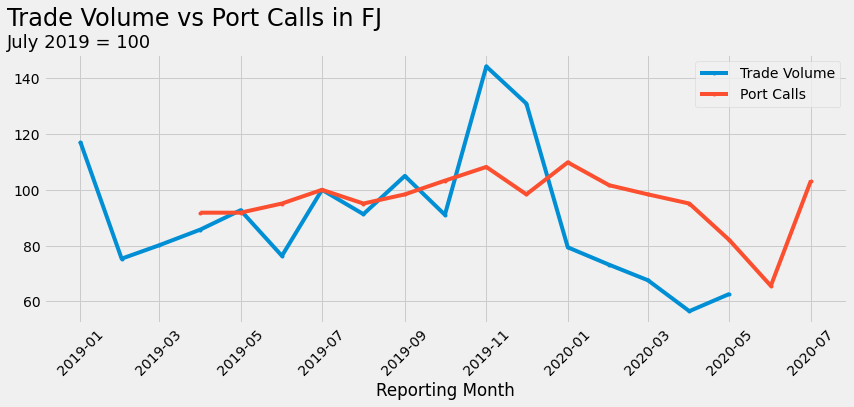

In [43]:
import matplotlib.style as style
style.use('fivethirtyeight')
plt.clf
f = plt.figure(figsize=(12,6))

ax = f.add_subplot(111)

plt.plot(data_merge[data_merge.country=='fj'].date
         ,data_merge[data_merge.country=='fj'].trade_volume_norm
         ,marker='.'
         ,label = 'Trade Volume')

plt.plot(data_merge[data_merge.country=='fj'].date
         ,data_merge[data_merge.country=='fj'].port_calls_norm
         ,marker='.'
         ,label = 'Port Calls')

plt.xticks(rotation=45)
plt.xlabel("Reporting Month")
plt.ylabel("")
plt.legend(loc='upper right')

plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.suptitle('Trade Volume vs Port Calls in FJ\n',x=0.01, y=.975,fontsize=24,ha='left')
plt.figtext(0.01,0.88,'July 2019 = 100',fontdict={'fontsize':18,'ha':'left'})

plt.show()

In [48]:
len(data_merge.country.unique().tolist())

6

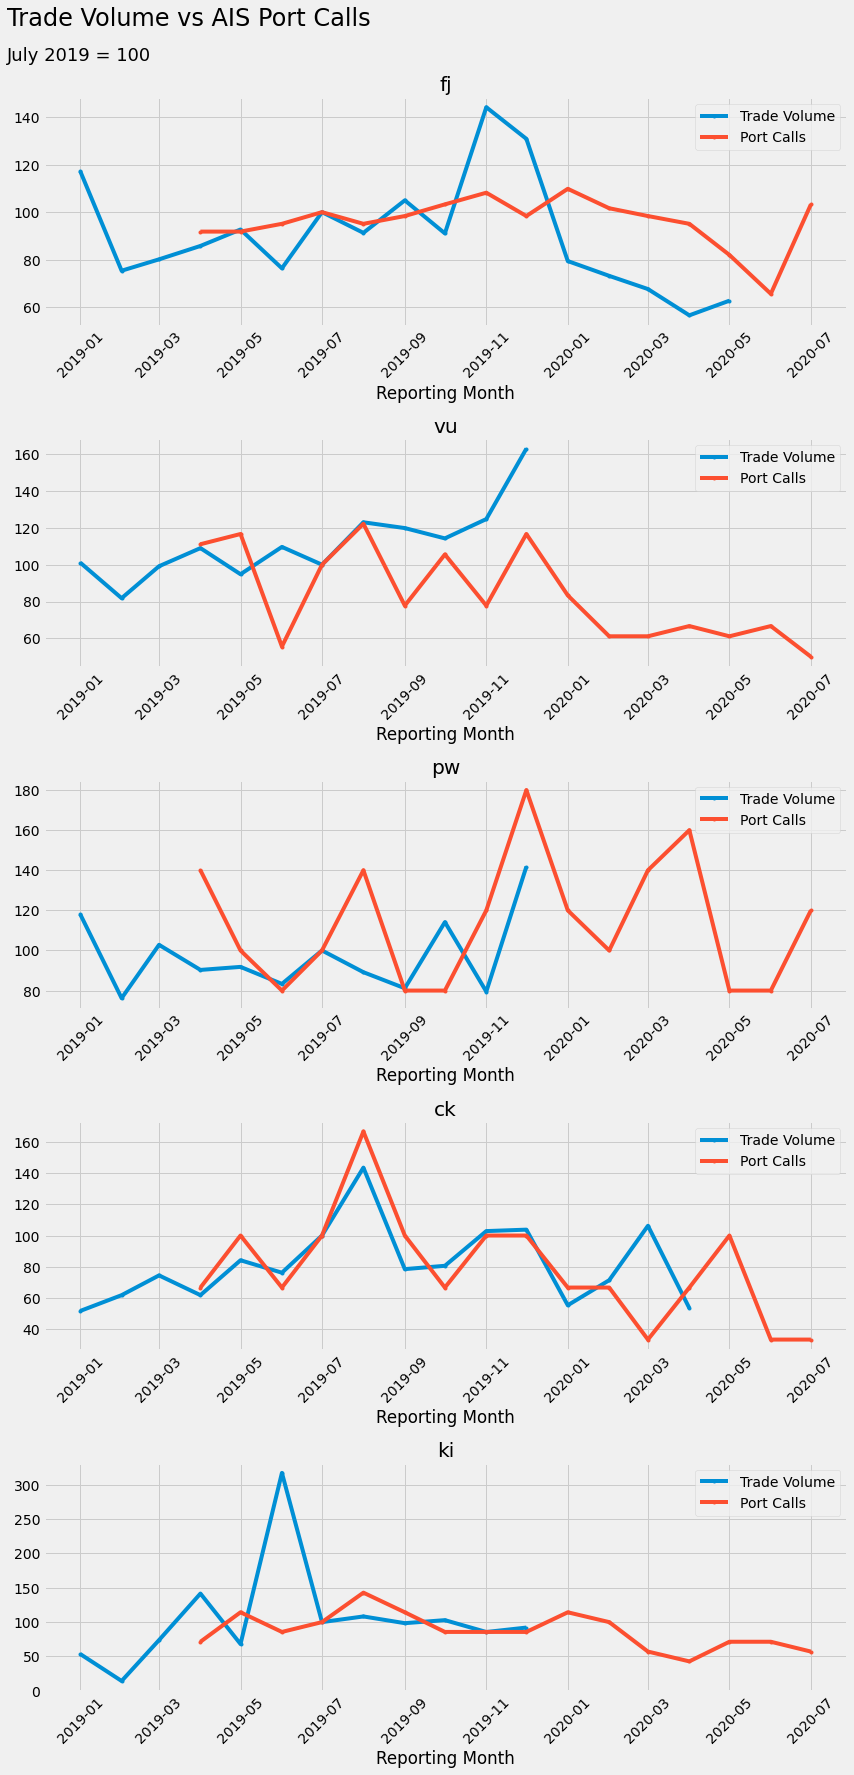

In [60]:
import matplotlib.style as style
style.use('fivethirtyeight')
plt.clf
n = 1
l = len(data_merge.country.unique().tolist())

f = plt.figure(figsize=(12,6*l))

for c in data_merge.country.unique().tolist():

    ax = f.add_subplot(6,1,n)

    plt.plot(data_merge[data_merge.country==c].date
             ,data_merge[data_merge.country==c].trade_volume_norm
             ,marker='.'
             ,label = 'Trade Volume')

    plt.plot(data_merge[data_merge.country==c].date
             ,data_merge[data_merge.country==c].port_calls_norm
             ,marker='.'
             ,label = 'Port Calls')

    plt.xticks(rotation=45)
    plt.xlabel("Reporting Month")
    plt.ylabel("")
    plt.legend(loc='upper right')
    plt.title(c)
    n+=1

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Trade Volume vs AIS Port Calls\n',x=0.01, y=.975,fontsize=24,ha='left')
plt.figtext(0.01,0.95,'July 2019 = 100',fontdict={'fontsize':18,'ha':'left'})    
plt.show()

# What's happened with visits and GDP

In [89]:
data_visits = pd.read_sql("""
select * from public.stg_tourism_agg 
where (country = 'vn' and date >= '2019-01-01') or (country <> 'vn' and date >= '2018-01-01')
""",con=engine,parse_dates='date')
data_visits.visitor_arrivals = pd.to_numeric(data_visits.visitor_arrivals,errors='coerce')
display(data_visits.info(),data_visits.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              95 non-null     datetime64[ns]
 1   region            95 non-null     object        
 2   country           95 non-null     object        
 3   visitor_arrivals  95 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.1+ KB


None

,date,region,country,visitor_arrivals
0,2019-03-01,melanesia,vn,19263.0
1,2019-04-01,melanesia,vn,19185.0
2,2019-05-01,melanesia,vn,15819.0
3,2019-06-01,melanesia,vn,18162.0
4,2019-07-01,melanesia,vn,23340.0


In [103]:
data_baseline = data_visits[(((data_visits.country != 'vn') & (data_visits.date == '2018-01-01')) | 
    ((data_visits.country == 'vn') & (data_visits.date == '2019-03-01')))].copy()
data_visits_prep = data_visits.merge(data_baseline[['country','visitor_arrivals']],on=['country'])
data_visits_prep['visitors'] = 100*data_visits_prep.visitor_arrivals_x/data_visits_prep.visitor_arrivals_y

In [65]:
pd.read_sql("""
select distinct country from public.stg_tourism_agg
""",con=engine)

,country
0,fj
1,vn
2,ck
3,pw


In [85]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

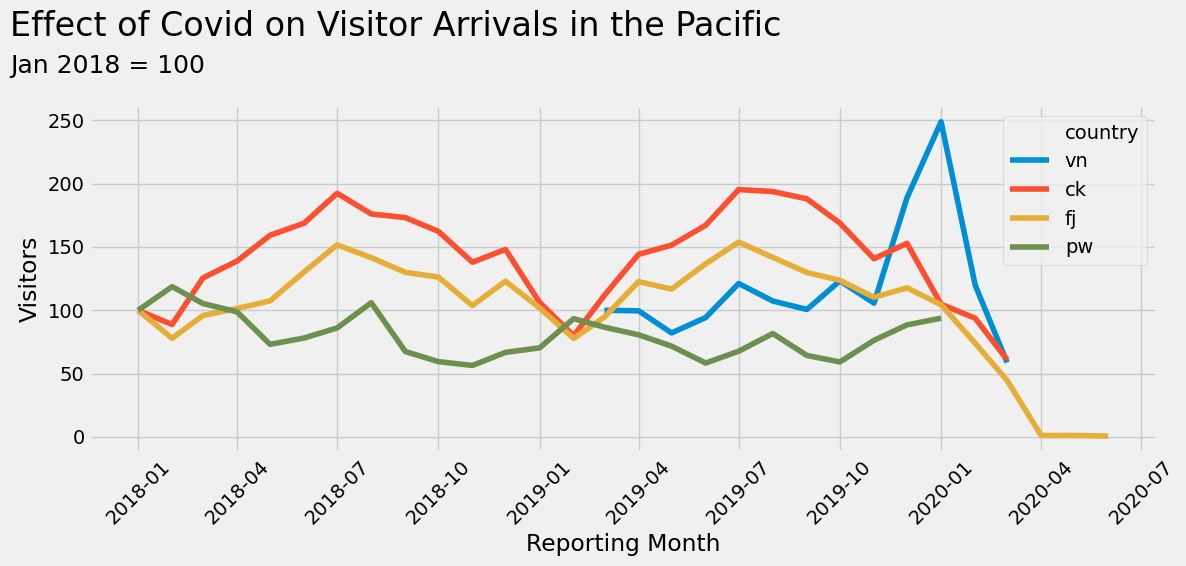

In [122]:
style.use('fivethirtyeight')
plt.clf
f = plt.figure(figsize=(12,6))
sns.lineplot(x='date',y='visitors',hue='country', data=data_visits_prep)

plt.xlabel("Reporting Month")
plt.ylabel("Visitors")
plt.xticks(rotation=45)
plt.legend(loc='upper right')

plt.tight_layout(rect=[0, 0.03, 1, 0.85])
plt.suptitle('Effect of Covid on Visitor Arrivals in the Pacific\n',x=0.01, y=.975,fontsize=24,ha='left')
plt.figtext(0.01,0.87,'Jan 2018 = 100',fontdict={'fontsize':18,'ha':'left'})    
plt.show()

In [132]:
data_visits_prep['year'] = data_visits_prep.date.dt.year.astype('str')
data_visits_prep['month'] = data_visits_prep.date.dt.month

In [133]:
data_visits_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 0 to 94
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                95 non-null     datetime64[ns]
 1   region              95 non-null     object        
 2   country             95 non-null     object        
 3   visitor_arrivals_x  95 non-null     float64       
 4   visitor_arrivals_y  95 non-null     float64       
 5   visitors            95 non-null     float64       
 6   year                95 non-null     object        
 7   month               95 non-null     int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 6.7+ KB


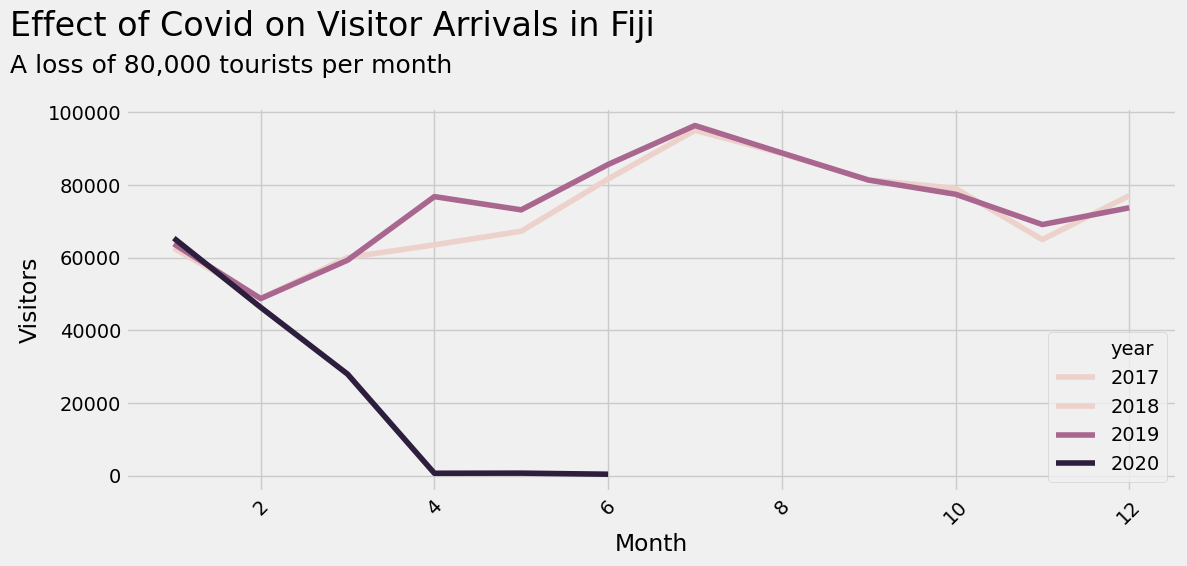

In [135]:
style.use('fivethirtyeight')
plt.clf
f = plt.figure(figsize=(12,6))
sns.lineplot(x='month',y='visitor_arrivals_x',hue='year', data=data_visits_prep[data_visits_prep.country=='fj'])

plt.xlabel("Month")
plt.ylabel("Visitors")
plt.xticks(rotation=45)
plt.legend(loc='lower right')

plt.tight_layout(rect=[0, 0.03, 1, 0.85])
plt.suptitle('Effect of Covid on Visitor Arrivals in Fiji\n',x=0.01, y=.975,fontsize=24,ha='left')
plt.figtext(0.01,0.87,'A loss of 80,000 tourists per month',fontdict={'fontsize':18,'ha':'left'})    
plt.show()

In [120]:
data_visits_prep[data_visits_prep.country=='fj']

,date,region,country,visitor_arrivals_x,visitor_arrivals_y,visitors,year,month
40,2018-01-01,melanesia,fj,62648.0,62648.0,100.000000,2018,1
41,2018-02-01,melanesia,fj,48798.0,62648.0,77.892351,2018,2
42,2018-03-01,melanesia,fj,60058.0,62648.0,95.865790,2018,3
43,2018-04-01,melanesia,fj,63535.0,62648.0,101.415847,2018,4
44,2018-05-01,melanesia,fj,67290.0,62648.0,107.409654,2018,5
45,2018-06-01,melanesia,fj,81653.0,62648.0,130.336164,2018,6
46,2018-07-01,melanesia,fj,95061.0,62648.0,151.738284,2018,7
47,2018-08-01,melanesia,fj,88693.0,62648.0,141.573554,2018,8
48,2018-09-01,melanesia,fj,81437.0,62648.0,129.991380,2018,9
49,2018-10-01,melanesia,fj,79077.0,62648.0,126.224301,2018,10


In [73]:
data_visits[data_visits.country=='vn']

,date,region,country,visitor_arrivals
0,2019-03-01,melanesia,vn,19263.0
1,2019-04-01,melanesia,vn,19185.0
2,2019-05-01,melanesia,vn,15819.0
3,2019-06-01,melanesia,vn,18162.0
4,2019-07-01,melanesia,vn,23340.0
5,2019-08-01,melanesia,vn,20677.0
6,2019-09-01,melanesia,vn,19390.0
7,2019-10-01,melanesia,vn,23743.0
8,2019-11-01,melanesia,vn,20353.0
9,2019-12-01,melanesia,vn,36381.0


# Scratch

In [17]:
# are the countries available?
pd.read_sql(
"""
select distinct name, country
from public.country_metrics
where true
and category = 'trade'
and country in ('fj','vu','ck','ki','pw','sb')
order by 1
"""
,con=engine)

,name,country
0,exports-fob-domestic,fj
1,exports-fob-domestic,sb
2,exports-fob-domestic,ki
3,exports-fob-domestic,ck
4,exports-fob-reexport,sb
5,exports-fob-reexport,ki
6,exports-fob-reexport,ck
7,exports-fob-reexport,fj
8,exports-fob-total,ki
9,exports-fob-total,fj


In [15]:
pd.read_sql(
"""
select name, country, frequency, min(date), max(date)
from public.country_metrics
where true
and category = 'CPI'
-- and country in ('fj','vu','ck','ki','pw','sb','PW','kir')
group by 1,2,3
order by 1,2,3

"""
,con=engine
)

,name,country,frequency,min,max
0,CPI_2006_ALCOHOL/TOBACCO,kir,monthly,2018-01-01,2019-12-01
1,CPI_2006_ALL ITEMS,kir,monthly,2018-01-01,2019-12-01
2,CPI_2006_CLOTHING,kir,monthly,2018-01-01,2019-12-01
3,CPI_2006_EDUCATION & HEALTH,kir,monthly,2018-01-01,2019-12-01
4,CPI_2006_FOOD,kir,monthly,2018-01-01,2019-12-01
5,CPI_2006_HOUSEHOLD OPERATION,kir,monthly,2018-01-01,2019-12-01
6,CPI_2006_HOUSING,kir,monthly,2018-01-01,2019-12-01
7,CPI_2006_NON-ALCOHOLIC DRINKS,kir,monthly,2018-01-01,2019-12-01
8,CPI_2006_RECREATION,kir,monthly,2018-01-01,2019-12-01
9,CPI_2006_TRANSPORTATION,kir,monthly,2018-01-01,2019-12-01


In [16]:
pd.read_sql(
"""
select name, country, frequency, min(date), max(date)
from public.country_metrics
where true
and category = 'tourism'
-- and country in ('fj','vu','ck','ki','pw','sb','PW','kir')
group by 1,2,3
order by 1,2,3

"""
,con=engine
)

,name,country,frequency,min,max
0,arrivals-resident,ck,monthly,2018-01-01 00:00:00,2020-03-01 00:00:00
1,arrivals-resident,fj,monthly,2018-01-01 00:00:00,2020-06-01 00:00:00
2,arrivals-resident,sb,quarterly,2016-01-01 00:00:00,2020-01-01 00:00:00
3,arrivals-total,ck,monthly,2018-01-01 00:00:00,2020-03-01 00:00:00
4,arrivals-total,fj,monthly,2018-01-01 00:00:00,2020-06-01 00:00:00
5,arrivals-total,sb,quarterly,2016-01-01 00:00:00,2020-01-01 00:00:00
6,arrivals-visitor,ck,monthly,2018-01-01 00:00:00,2020-03-01 00:00:00
7,arrivals-visitor,fj,monthly,2018-01-01 00:00:00,2020-06-01 00:00:00
8,arrivals-visitor,sb,quarterly,2016-01-01 00:00:00,2020-01-01 00:00:00
9,departures-resident,ck,monthly,2018-01-01 00:00:00,2020-03-01 00:00:00
